# DALYA (Automated Learning and Inference for Causal Effects)

- Setup;
- Import tables;
- Transform;
- Export `.csv`.

# 0. Setup

In [7]:
#standard packages
import pandas as pd
import numpy as np
import os
#import warnings
import warnings
warnings.filterwarnings('ignore')

#machine-learning packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import dowhy
from dowhy import CausalModel

#image, visualization
import matplotlib.pyplot as plt
import seaborn as sns

***

# 1. Import transformed table & pre-(pre-process)

In [8]:
sm_df = pd.read_csv('/Users/luiz.superti/Documents/GitHub/alice-coding/ML-models/dalya/csv/alice_sm_train_df.csv')
sm_df.drop(columns = 'member_internal_code', inplace = True)

sm_df['daly_t0'].fillna(0, inplace = True)
sm_df['daly_t0'] = sm_df['daly_t0']
sm_df['daly_t1'].fillna(0, inplace = True)
sm_df['daly_t1'] = sm_df['daly_t1']

sm_df['delta_daly'] = sm_df['daly_t1'] - sm_df['daly_t0']
sm_df.loc[sm_df['treatment_group']==0, 'discharged'] = 1 - sm_df['discharged']
sm_df.head(5)

,program_name,program_severity,is_male,is_trans,member_age,total_mths,psico_qt_consultas,psiqui_qt_consultas,discharged,psico_custos_tot,psiqui_custos_tot,treatment_group,daly_t0,daly_t1,delta_daly
0,Ansiedade LEVE,leve,1,0,35.0,14,9.0,0.0,0,0.0,0.0,1,0.030,0.030,0.000
1,Ansiedade MODERADA,moderada,1,0,36.0,3,1.0,0.0,0,150.0,0.0,1,0.030,0.030,0.000
2,Ansiedade LEVE,leve,0,0,32.0,8,7.0,0.0,0,560.0,0.0,1,0.030,0.523,0.493
3,Transtorno Tipo 1,tipo 1,0,0,33.0,4,5.0,0.0,1,630.0,0.0,1,0.523,0.000,-0.523
4,Transtorno Tipo 1,tipo 1,0,0,26.0,6,6.0,3.0,1,750.0,1050.0,1,0.000,0.000,0.000


In [9]:
### Treatment
sm_df['base_control'] = np.where(sm_df['treatment_group']==0,1,0)
sm_df['treatment_0_4'] = np.where((sm_df['treatment_group']==1) & (sm_df['psico_qt_consultas']>=4) & (sm_df['psico_qt_consultas']<=7),1,0)
sm_df['treatment_5_10'] = np.where((sm_df['treatment_group']==1) & (sm_df['psico_qt_consultas']>=8) & (sm_df['psico_qt_consultas']<=11),1,0)
sm_df['treatment_11_'] = np.where((sm_df['treatment_group']==1) & (sm_df['psico_qt_consultas']>11),1,0)
sm_df['treatment_0_10'] = np.where((sm_df['treatment_group']==1) & (sm_df['psico_qt_consultas']>=0) & (sm_df['psico_qt_consultas']<=10),1,0)

In [10]:
ml_df = sm_df[((sm_df['program_severity'].isna()==True)|(sm_df['program_severity']=='tipo 1')|(sm_df['program_severity']=='tipo 2'))][['member_age','is_male','daly_t0', 'delta_daly','base_control','treatment_0_4','psico_custos_tot','treatment_0_10', 'treatment_5_10', 'treatment_11_', 'discharged', 'total_mths']]

In [11]:
#cATT(d|d), for d = treat_0_10
#We have to restrict base control and treatment_0_10
catt_dd_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_0_10']==1)]
catt_dd_df['treat'] = np.where(catt_dd_df.treatment_0_10==1,1,0)

In [12]:
catt_dd_df.head(10)

,member_age,is_male,daly_t0,delta_daly,base_control,treatment_0_4,psico_custos_tot,treatment_0_10,treatment_5_10,treatment_11_,discharged,total_mths,treat
3,33.0,0,0.523,-0.523,0,1,630.0,1,0,0,1,4,1
4,26.0,0,0.000,0.000,0,1,750.0,1,0,0,1,6,1
5,26.0,0,0.032,-0.032,0,0,300.0,1,0,0,1,9,1
6,33.0,0,0.000,0.000,0,0,0.0,1,0,0,0,7,1
9,26.0,0,0.132,-0.132,0,1,2400.0,1,0,0,1,6,1
14,27.0,1,0.523,-0.523,0,0,630.0,1,0,0,1,4,1
16,25.0,0,0.000,0.000,0,1,1500.0,1,0,0,0,5,1
17,29.0,0,0.523,-0.523,0,0,750.0,1,0,0,1,3,1
18,29.0,0,0.568,-0.568,0,1,1350.0,1,0,0,1,4,1
19,30.0,0,0.000,0.000,0,1,3300.0,1,0,0,1,11,1


In [15]:
base_model = CausalModel(data = ml_df[['discharged','treatment_0_10','daly_t0', 'member_age', 'is_male']],
                         treatment = 'treatment_0_10',
                         outcome= 'delta_daly',
                         common_causes = ['member_age', 'is_male'])


In [16]:
catt_dd_df[catt_dd_df['base_control']==1]['discharged'].value_counts()

0    851
1     53
Name: discharged, dtype: int64

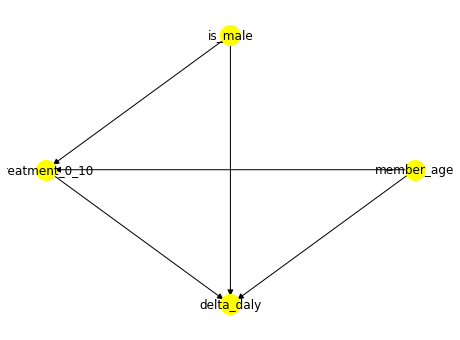

In [17]:
base_model.view_model()

In [33]:
identified_estimand = base_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                  
────────────────(E[discharged|is_male,daly_t0,member_age])
d[treatment₀ ₁₀]                                          
Estimand assumption 1, Unconfoundedness: If U→{treatment_0_10} and U→discharged then P(discharged|treatment_0_10,is_male,daly_t0,member_age,U) = P(discharged|treatment_0_10,is_male,daly_t0,member_age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



No Dowhy, primeiro precisamos setar o baseModel, que é onde deixamos o dataframe pandas, com as variaveis tratamento, outcome, e covariadas (common causes). A instancia .identifiy_effect faz o grafico para mostrar o estimando do efeito causal.


Para o nosso DRDiD, precisamos modificar o .estimate_effect, que entra o identified estimand, com um method_name). O method name é que entraria o DRDiD mais simples

In [ ]:
estimate = base_model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

****

In [18]:
import dowhy.datasets 
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False,
        stddev_treatment_noise=10)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.845201,-1.941082,0.519187,0.644934,0.001550,1.149972,True,8.017748
1,0.0,0.837583,-1.368542,-1.295909,1.320892,0.426058,0.763225,True,9.435173
2,0.0,0.253142,-2.837295,-2.296692,-0.074001,0.928185,0.828946,False,-10.152664
3,0.0,0.870248,1.114219,-4.152724,0.421994,0.620473,-1.095595,True,7.860360
4,0.0,0.883528,0.152124,0.215479,1.532346,0.929882,-0.997254,True,14.840956
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.987641,1.655326,-1.868185,0.343719,-0.054250,1.255434,True,17.862407
9996,1.0,0.283482,-1.427279,-2.201633,-1.436415,-0.972712,-1.500732,False,-19.499982
9997,0.0,0.425376,0.670560,0.398291,-0.491913,0.721454,1.925341,True,19.046494
9998,1.0,0.316240,-2.841384,-0.144855,1.200957,2.157929,0.423847,True,8.711185


In [19]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

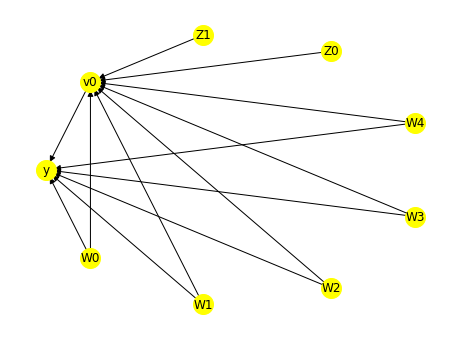

In [20]:
model.view_model()


In [22]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W4,W0,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W4,W0,W3,U) = P(y|v0,W2,W1,W4,W0,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



***

In [48]:
#probability weights for ATE and cATE
P_D_ = 1-np.mean(ml_df.base_control)
p_treat_0_4 = np.mean(ml_df.treatment_0_4)/(1-np.mean(ml_df.base_control))
p_treat_5_10 = np.mean(ml_df.treatment_5_10)/(1-np.mean(ml_df.base_control))
p_treat_11_ = np.mean(ml_df.treatment_11_)/(1-np.mean(ml_df.base_control))

In [49]:
p_treat_0_10 = np.mean(ml_df.treatment_0_10)/(1-np.mean(ml_df.base_control))

In [50]:
print(p_treat_0_4,p_treat_5_10, p_treat_11_)

0.4517766497461929 0.18274111675126903 0.04568527918781726


In [51]:
p_treat_0_10

0.9238578680203047

In [40]:
from setup import main as setup
setup(env='vscode', project='dalya')
from src.model import DrDidEstimator
dr_did = DrDidEstimator()

Project directory: /Users/luiz.superti/Documents/GitHub/alice-coding/ML-models/dalya


FULL ATE

In [ ]:
catt_dd_df.loc[catt_dd_df['treat']==0, 'discharged'] 

In [47]:
#cATT(d|d), for d = treat_0_10
#We have to restrict base control and treatment_0_10
catt_dd_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_0_10']==1)]
catt_dd_df['treat'] = np.where(catt_dd_df.treatment_0_10==1,1,0)
#catt_dd_df.loc[catt_dd_df['treat']==0, 'discharged'] = (catt_dd_df['discharged'] -1) * -1 

care_cost_dd = np.sum(-catt_dd_df[catt_dd_df['discharged']==1]['delta_daly'])/np.sum(catt_dd_df[catt_dd_df['treat']==1]['psico_custos_tot'])

#catt_da_df
#We have to restrict the first alternative treatment a, and treatment_5_10, but ask for the base_control
dr_did.fit(catt_dd_df[['member_age', 'is_male']].to_numpy(),catt_dd_df.treat, catt_dd_df.discharged) 
catt_dd = dr_did.att_mean
catt_dd_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_dd_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)


IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True


In [48]:
catt_dd_df[['treat', 'discharged']].value_counts()

treat  discharged
0      0             851
1      1             484
       0              94
0      1              53
dtype: int64

In [44]:
print(catt_dd_lb, catt_dd, catt_dd_ub)

-0.11548015809580384 -0.07559574319549403 -0.03571132829518423


#### ATE for d = 5 to 8

In [55]:
#cATT(d|d), for d = treat_5_10
#We have to restrict base control and treatment_5_10
catt_dd_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_5_10']==1)]
catt_dd_df['treat'] = np.where(catt_dd_df.treatment_5_10==1,1,0)

care_cost_dd = np.sum(-catt_dd_df[catt_dd_df['discharged']==1]['delta_daly'])/np.sum(catt_dd_df[catt_dd_df['treat']==1]['psico_custos_tot'])

#catt_da_df
#We have to restrict the first alternative treatment a, and treatment_5_10, but ask for the base_control
catt_aa_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_0_4']==1)]
catt_aa_df['treat']  = np.where(catt_aa_df.treatment_0_4==1,1,0)
catt_ad_df = ml_df[(ml_df['treatment_0_4']==1)|(ml_df['treatment_5_10']==1)]
catt_ad_df['treat']  = np.where(catt_ad_df.treatment_5_10==1,1,0)

#care-costs a/d
nd = len(catt_ad_df[catt_ad_df['treat']==1]['treat'])
cc_d = np.mean(catt_ad_df[catt_ad_df['treat']==1]['psico_custos_tot'])
cc_a = np.mean(catt_ad_df[catt_ad_df['treat']==0]['psico_custos_tot'])

care_cost_da = np.sum(-catt_ad_df[catt_ad_df['treat']==1]['delta_daly'])/(nd*cc_d) - np.sum(catt_ad_df[catt_ad_df['treat']==1]['delta_daly'])/(nd*cc_a)

#We have to restrict the first alternative treatment b, and treatment_5_10, but ask for the base_control
catt_bb_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_11_']==1)]
catt_bb_df['treat'] = np.where(catt_bb_df.treatment_11_==1,1,0)
catt_bd_df = ml_df[(ml_df['treatment_11_']==1)|(ml_df['treatment_5_10']==1)]
catt_bd_df['treat']  = np.where(catt_bd_df.treatment_5_10==1,1,0)

#care-costs b/d
nd = len(catt_bd_df[catt_bd_df['treat']==1]['treat'])
cc_d = np.mean(catt_bd_df[catt_bd_df['treat']==1]['psico_custos_tot'])
cc_b = np.mean(catt_bd_df[catt_bd_df['treat']==0]['psico_custos_tot'])

care_cost_db = np.sum(-catt_bd_df[catt_bd_df['treat']==1]['delta_daly'])/(nd*cc_d) - np.sum(catt_bd_df[catt_bd_df['treat']==1]['delta_daly'])/(nd*cc_b)

#catt_dd
dr_did.fit(catt_dd_df[['member_age', 'is_male']].to_numpy(),catt_dd_df.treat, catt_dd_df.discharged) 
catt_dd = p_treat_5_10*dr_did.att_mean
catt_dd_lb = p_treat_5_10*(dr_did.att_mean - 1.96*dr_did.att_sd)
catt_dd_ub = p_treat_5_10*(dr_did.att_mean + 1.96*dr_did.att_sd)

#catt_da
dr_did.fit(catt_aa_df[['member_age', 'is_male']].to_numpy(),catt_aa_df.treat, catt_aa_df.discharged) 
catt_aa = dr_did.att_mean
catt_aa_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_aa_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)
dr_did.fit(catt_ad_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_ad_df.treat, catt_ad_df.discharged) 
catt_ad = dr_did.att_mean
catt_ad_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_ad_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)
catt_da = p_treat_0_4*(catt_aa-catt_ad)
catt_da_lb = p_treat_0_4*np.fmin((catt_aa_lb-catt_ad_ub),(catt_aa_lb - catt_ad_lb))
catt_da_ub = p_treat_0_4*np.fmax((catt_aa_ub-catt_ad_ub),(catt_aa_ub - catt_ad_lb)) 

#catt_db
dr_did.fit(catt_bb_df[['member_age', 'is_male']].to_numpy(),catt_bb_df.treat, catt_bb_df.discharged) 
catt_bb = dr_did.att_mean
catt_bb_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_bb_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)
dr_did.fit(catt_bd_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_bd_df.treat, catt_bd_df.discharged) 
catt_bd = dr_did.att_mean
catt_bd_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_bd_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)
catt_db = p_treat_11_*(catt_bb-catt_bd)
catt_db_lb = p_treat_11_*np.fmin((catt_bb_lb-catt_bd_ub),(catt_bb_lb - catt_bd_lb))
catt_db_ub = p_treat_11_*np.fmax((catt_bb_ub-catt_bd_ub),(catt_bb_ub - catt_bd_lb))

##############
ate_5_10 = catt_dd + catt_da + catt_db
ate_5_10_lb = catt_dd_lb + catt_da_lb + catt_db_lb
ate_5_10_ub = catt_dd_ub + catt_da_ub + catt_db_ub

cost_eff_5_10 = 10000*(care_cost_dd*catt_dd + care_cost_da*catt_da + care_cost_db*catt_db)
cost_eff_5_10_lb = 10000*(care_cost_dd*catt_dd_lb + care_cost_da*catt_da_lb + care_cost_db*catt_db_lb)
cost_eff_5_10_ub = 10000*(care_cost_dd*catt_dd_ub + care_cost_da*catt_da_ub + care_cost_db*catt_db_ub)

IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True


#### ATE for d = 0 to 4

In [56]:
#cATT(d|d), for d = treat_0_4
#We have to restrict base control and treatment_0_4
catt_dd_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_0_4']==1)]
catt_dd_df['treat'] = np.where(catt_dd_df.treatment_0_4==1,1,0)

care_cost_dd = np.sum(-catt_dd_df[catt_dd_df['discharged']==1]['delta_daly'])/np.sum(catt_dd_df[catt_dd_df['treat']==1]['psico_custos_tot'])

#catt_da_df
#We have to restrict the first alternative treatment a, and d, but ask for the base_control
catt_aa_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_5_10']==1)]
catt_aa_df['treat'] = np.where(catt_aa_df.treatment_5_10==1,1,0)
catt_ad_df = ml_df[(ml_df['treatment_5_10']==1)|(ml_df['treatment_0_4']==1)]
catt_ad_df['treat'] = np.where(catt_ad_df.treatment_0_4==1,1,0)

#care-costs a/d
nd = len(catt_ad_df[catt_ad_df['treat']==1]['treat'])
cc_d = np.mean(catt_ad_df[catt_ad_df['treat']==1]['psico_custos_tot'])
cc_a = np.mean(catt_ad_df[catt_ad_df['treat']==0]['psico_custos_tot'])

care_cost_da = np.sum(-catt_ad_df[catt_ad_df['treat']==1]['delta_daly'])/(nd*cc_d) - np.sum(catt_ad_df[catt_ad_df['treat']==1]['delta_daly'])/(nd*cc_a)

#We have to restrict the first alternative treatment b, and d, but ask for the base_control
catt_bb_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_11_']==1)]
catt_bb_df['treat'] = np.where(catt_bb_df.treatment_11_==1,1,0)
catt_bd_df = ml_df[(ml_df['treatment_11_']==1)|(ml_df['treatment_0_4']==1)]
catt_bd_df['treat'] = np.where(catt_bd_df.treatment_0_4==1,1,0)

#care-costs b/d
nd = len(catt_bd_df[catt_bd_df['treat']==1]['treat'])
cc_d = np.mean(catt_bd_df[catt_bd_df['treat']==1]['psico_custos_tot'])
cc_b = np.mean(catt_bd_df[catt_bd_df['treat']==0]['psico_custos_tot'])

care_cost_db = np.sum(-catt_bd_df[catt_bd_df['treat']==1]['delta_daly'])/(nd*cc_d) - np.sum(catt_bd_df[catt_bd_df['treat']==1]['delta_daly'])/(nd*cc_b)

#catt_dd
dr_did.fit(catt_dd_df[['member_age', 'is_male']].to_numpy(),catt_dd_df.treat, catt_dd_df.discharged) 
catt_dd = p_treat_0_4*dr_did.att_mean
catt_dd_lb = p_treat_0_4*(dr_did.att_mean - 1.96*dr_did.att_sd)
catt_dd_ub = p_treat_0_4*(dr_did.att_mean + 1.96*dr_did.att_sd)

#catt_da
dr_did.fit(catt_aa_df[['member_age', 'is_male']].to_numpy(),catt_aa_df.treat, catt_aa_df.discharged) 
catt_aa = dr_did.att_mean
catt_aa_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_aa_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)
dr_did.fit(catt_ad_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_ad_df.treat, catt_ad_df.discharged) 
catt_ad = dr_did.att_mean
catt_ad_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_ad_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)

catt_da = p_treat_5_10*(catt_aa-catt_ad)
catt_da_lb = p_treat_5_10*np.fmin((catt_aa_lb-catt_ad_ub),(catt_aa_lb - catt_ad_lb))
catt_da_ub = p_treat_5_10*np.fmax((catt_aa_ub-catt_ad_ub),(catt_aa_ub - catt_ad_lb)) 

#catt_db
dr_did.fit(catt_bb_df[['member_age', 'is_male']].to_numpy(),catt_bb_df.treat, catt_bb_df.discharged) 
catt_bb = dr_did.att_mean
catt_bb_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_bb_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)
dr_did.fit(catt_bd_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_bd_df.treat, catt_bd_df.discharged) 
catt_bd = dr_did.att_mean
catt_bd_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_bd_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)

catt_db = p_treat_11_*(catt_bb-catt_bd)
catt_db_lb = p_treat_11_*np.fmin((catt_bb_lb-catt_bd_ub),(catt_bb_lb - catt_bd_lb))
catt_db_ub = p_treat_11_*np.fmax((catt_bb_ub-catt_bd_ub),(catt_bb_ub - catt_bd_lb))


#
ate_0_4 = catt_dd + catt_da + catt_db
cost_eff_0_4 = 10000*(care_cost_dd*catt_dd + care_cost_da*catt_da + care_cost_db*catt_db)  
cost_eff_0_4_lb = 10000*(care_cost_dd*catt_dd_lb + care_cost_da*catt_da_lb + care_cost_db*catt_db_lb)
cost_eff_0_4_ub = 10000*(care_cost_dd*catt_dd_ub + care_cost_da*catt_da_ub + care_cost_db*catt_db_ub)

IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True


#### ATE for d >= 9

In [57]:
#cATT(d|d), for d = treat_11_
#We have to restrict base control and treatment_0_4
catt_dd_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_11_']==1)]
catt_dd_df['treat'] = np.where(catt_dd_df.treatment_11_==1,1,0)

care_cost_dd = np.sum(-catt_dd_df[catt_dd_df['discharged']==1]['delta_daly'])/np.sum(catt_dd_df[catt_dd_df['treat']==1]['psico_custos_tot'])

#catt_da_df
#We have to restrict the first alternative treatment a, and d, but ask for the base_control
catt_aa_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_0_4']==1)]
catt_aa_df['treat'] = np.where(catt_aa_df.treatment_0_4==1,1,0)
catt_ad_df = ml_df[(ml_df['treatment_0_4']==1)|(ml_df['treatment_11_']==1)]
catt_ad_df['treat'] = np.where(catt_ad_df.treatment_11_==1,1,0)


#care-costs a/d
nd = len(catt_ad_df[catt_ad_df['treat']==1]['treat'])
cc_d = np.mean(catt_ad_df[catt_ad_df['treat']==1]['psico_custos_tot'])
cc_a = np.mean(catt_ad_df[catt_ad_df['treat']==0]['psico_custos_tot'])

care_cost_da = np.sum(-catt_ad_df[catt_ad_df['treat']==1]['delta_daly'])/(nd*cc_d) - np.sum(catt_ad_df[catt_ad_df['treat']==1]['delta_daly'])/(nd*cc_a)



#We have to restrict the first alternative treatment b, and d, but ask for the base_control
catt_bb_df = ml_df[(ml_df['base_control']==1)|(ml_df['treatment_5_10']==1)]
catt_bb_df['treat'] = np.where(catt_bb_df.treatment_5_10==1,1,0)
catt_bd_df = ml_df[(ml_df['treatment_5_10']==1)|(ml_df['treatment_11_']==1)]
catt_bd_df['treat'] = np.where(catt_bd_df.treatment_11_==1,1,0)



#care-costs b/d
nd = len(catt_bd_df[catt_bd_df['treat']==1]['treat'])
cc_d = np.mean(catt_bd_df[catt_bd_df['treat']==1]['psico_custos_tot'])
cc_b = np.mean(catt_bd_df[catt_bd_df['treat']==0]['psico_custos_tot'])

care_cost_db = np.sum(-catt_bd_df[catt_bd_df['treat']==1]['delta_daly'])/(nd*cc_d) - np.sum(catt_bd_df[catt_bd_df['treat']==1]['delta_daly'])/(nd*cc_b)

#catt_dd
dr_did.fit(catt_dd_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_dd_df.treat, catt_dd_df.discharged) 
catt_dd = p_treat_11_*dr_did.att_mean
catt_dd_lb = p_treat_11_*(dr_did.att_mean - 1.96*dr_did.att_sd)
catt_dd_ub = p_treat_11_*(dr_did.att_mean + 1.96*dr_did.att_sd)

#catt_da
dr_did.fit(catt_aa_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_aa_df.treat, catt_aa_df.discharged) 
catt_aa = dr_did.att_mean
catt_aa_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_aa_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)

dr_did.fit(catt_ad_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_ad_df.treat, catt_ad_df.discharged) 
catt_ad = dr_did.att_mean
catt_ad_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_ad_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)

catt_da = p_treat_0_4*(catt_aa-catt_ad)
catt_da_lb = p_treat_0_4*np.fmin((catt_aa_lb-catt_ad_ub),(catt_aa_lb - catt_ad_lb))
catt_da_ub = p_treat_0_4*np.fmax((catt_aa_ub-catt_ad_ub),(catt_aa_ub - catt_ad_lb)) 



#catt_db
dr_did.fit(catt_bb_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_bb_df.treat, catt_bb_df.discharged) 
catt_bb = dr_did.att_mean
catt_bd_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_bd_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)

dr_did.fit(catt_bd_df[['member_age', 'is_male', 'daly_t0']].to_numpy(),catt_bd_df.treat, catt_bd_df.discharged) 
catt_bd = dr_did.att_mean
catt_bd_lb = (dr_did.att_mean - 1.96*dr_did.att_sd)
catt_bd_ub = (dr_did.att_mean + 1.96*dr_did.att_sd)

catt_db = p_treat_5_10*(catt_bb-catt_bd)
catt_db_lb = p_treat_5_10*np.fmin((catt_bb_lb-catt_bd_ub),(catt_bb_lb - catt_bd_lb))
catt_db_ub = p_treat_5_10*np.fmax((catt_bb_ub-catt_bd_ub),(catt_bb_ub - catt_bd_lb))
#
ate_11_ = catt_dd + catt_da + catt_db
cost_eff_11_ = 10000*(care_cost_dd*catt_dd + care_cost_da*catt_da + care_cost_db*catt_db)  
cost_eff_11_lb = 10000*(care_cost_dd*catt_dd_lb + care_cost_da*catt_da_lb + care_cost_db*catt_db_lb)
cost_eff_11_ub = 10000*(care_cost_dd*catt_dd_ub + care_cost_da*catt_da_ub + care_cost_db*catt_db_ub)


IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True
IPT estimation started
IPT optimation success: True
WLS estimation started
WLS optimation success: True


#### cost-effectivenss prints

In [58]:
print(cost_eff_0_4_lb,cost_eff_0_4,cost_eff_0_4_ub)

0.9182066984453097 1.068132388198055 1.2180580779508001


In [59]:
print(cost_eff_5_10_lb,cost_eff_5_10,cost_eff_5_10_ub)

0.48069755905022965 0.597325010781185 0.7139524625121404


In [60]:
print(cost_eff_11_lb,cost_eff_11_,cost_eff_11_ub)

nan nan nan


***

# 2. Model & Analysis of cATE
